# Step 1 - Create DataFrame

First, the data needs to be imported for mining and manipulation. The data is fetched from CSV file and presented as Dask DataFrame.

<em>Next to common Anaconda3 packages, the <code>astral</code> package is required for moon phase calculations.</em>

In [1]:
# Configuration

columns = ['tr_build_id', 'tr_prev_build', 'tr_status', 'tr_log_status',
           'gh_build_started_at', 'gh_project_name', 'gh_sloc',
           'git_branch', 'git_num_all_built_commits']
with_moon = True

In [2]:
import dask.dataframe as pd
import pandas as px
import numpy as np

df = pd.read_csv("data/travistorrent_11_1_2017.csv",
                 usecols=columns, parse_dates=['gh_build_started_at'])
df = df.drop_duplicates()

if with_moon:
    from astral import Astral
    astral = Astral()
    city = astral['London'] # Use 'London' as location to reflect UTC timestamps
    moon = map(lambda x: city.moon_phase(date=x), df['gh_build_started_at'].compute())
    groups = df['gh_project_name'].compute().str.split('/', expand=True)
    groups.columns = ['group', 'project']
    weekday = map(lambda x: x.weekday(), df['gh_build_started_at'].compute())
    df = px.concat([df.compute(), groups], axis=1)
    df = df.assign(moon_phase = list(moon)).assign(weekday=list(weekday))


Combine with "previous build", add transition as 'status_update' (old:new), 'delta' between start times of the builds and create frame containing only builds where status changed.

In [3]:
df_false_pos = df[(df['tr_status'] == 'passed') & (df['tr_log_status'] != 'ok')]
df_follower = df[(df['tr_prev_build'] != np.nan) & (df['tr_prev_build'] > 0)]
df_with_prev = pd.merge(df_follower, df, left_on='tr_prev_build', right_on='tr_build_id', suffixes=('', '_prev'))
df_with_prev = df_with_prev.assign(delta = df_with_prev['gh_build_started_at'] - df_with_prev['gh_build_started_at_prev'])
df_with_prev = df_with_prev.assign(status_update = df_with_prev['tr_status_prev'] + ':' + df_with_prev['tr_status'])
df_with_change = df_with_prev[df_with_prev['tr_status'] != df_with_prev['tr_status_prev']]

There seem to be some previous builds that started in the future...

In [4]:
from datetime import timedelta

if with_moon:
    negative_deltas = df_with_prev[df_with_prev['delta'] < timedelta(0)].sort_values('delta')
else:
    negative_deltas = df_with_prev[df_with_prev['delta'] < timedelta(0)].compute().sort_values('delta')

negative_deltas

,tr_build_id,gh_project_name,git_branch,tr_prev_build,git_num_all_built_commits,gh_sloc,gh_build_started_at,tr_status,tr_log_status,group,...,gh_sloc_prev,gh_build_started_at_prev,tr_status_prev,tr_log_status_prev,group_prev,project_prev,moon_phase_prev,weekday_prev,delta,status_update
442748,35739610,caelum/tubaina,master,35656796.0,1,6992,2014-09-19 15:05:12,errored,unknown,caelum,...,6984,2016-02-04 18:53:09,errored,unknown,caelum,tubaina,23,3,-504 days +20:12:03,errored:errored
277557,22925036,topfunky/gruff,master,17244194.0,1,2331,2014-04-14 05:08:16,passed,ok,topfunky,...,2331,2015-05-30 22:17:42,passed,ok,topfunky,gruff,11,5,-412 days +06:50:34,passed:passed
277558,23664005,topfunky/gruff,master,17244194.0,1,2331,2014-04-24 10:31:01,passed,ok,topfunky,...,2331,2015-05-30 22:17:42,passed,ok,topfunky,gruff,11,5,-402 days +12:13:19,passed:passed
277559,27314542,topfunky/gruff,master,17244194.0,1,2333,2014-06-11 15:04:55,errored,unknown,topfunky,...,2331,2015-05-30 22:17:42,passed,ok,topfunky,gruff,11,5,-354 days +16:47:13,passed:errored
277560,27314542,topfunky/gruff,master,17244194.0,1,2333,2014-06-11 15:04:55,errored,ok,topfunky,...,2331,2015-05-30 22:17:42,passed,ok,topfunky,gruff,11,5,-354 days +16:47:13,passed:errored
379199,28225579,topfunky/gruff,master,27353384.0,1,2331,2014-06-23 13:57:57,errored,unknown,topfunky,...,2333,2015-05-30 21:59:11,failed,broken,topfunky,gruff,11,5,-342 days +15:58:46,failed:errored
379197,28225579,topfunky/gruff,master,27353384.0,1,2331,2014-06-23 13:57:57,errored,ok,topfunky,...,2333,2015-05-30 21:59:11,failed,broken,topfunky,gruff,11,5,-342 days +15:58:46,failed:errored
379196,28225579,topfunky/gruff,master,27353384.0,1,2331,2014-06-23 13:57:57,errored,ok,topfunky,...,2333,2015-05-30 21:59:11,failed,ok,topfunky,gruff,11,5,-342 days +15:58:46,failed:errored
379198,28225579,topfunky/gruff,master,27353384.0,1,2331,2014-06-23 13:57:57,errored,unknown,topfunky,...,2333,2015-05-30 21:59:11,failed,ok,topfunky,gruff,11,5,-342 days +15:58:46,failed:errored
72969,4734455,codebrew/backbone-rails,master,4536321.0,1,148,2013-02-11 23:51:45,passed,unknown,codebrew,...,148,2014-01-17 22:54:25,failed,broken,codebrew,backbone-rails,15,4,-340 days +00:57:20,failed:passed


... some of the builds where run on different branches ...

In [5]:
branch_changed = df_with_prev[df_with_prev['git_branch'] != df_with_prev['git_branch_prev']]
if not with_moon:
    branch_changed = branch_changed.compute()

branch_changed

,tr_build_id,gh_project_name,git_branch,tr_prev_build,git_num_all_built_commits,gh_sloc,gh_build_started_at,tr_status,tr_log_status,group,...,gh_sloc_prev,gh_build_started_at_prev,tr_status_prev,tr_log_status_prev,group_prev,project_prev,moon_phase_prev,weekday_prev,delta,status_update
14,108486,karmi/retire,proxy,108310.0,1,1759,2011-08-29 12:51:08,passed,unknown,karmi,...,1721,2011-08-29 12:42:29,passed,unknown,karmi,retire,0,0,0 days 00:08:39,passed:passed
153,117786,nov/fb_graph,ads,117598.0,2,2683,2011-09-01 04:11:43,failed,unknown,nov,...,2683,2011-09-01 04:04:21,failed,unknown,nov,fb_graph,3,3,0 days 00:07:22,failed:failed
203,121379,thoughtbot/factory_girl,rails-3-1,120009.0,1,1294,2011-09-02 15:04:20,passed,unknown,thoughtbot,...,1294,2011-09-01 22:23:00,passed,unknown,thoughtbot,factory_girl,3,3,0 days 16:41:20,passed:passed
205,121386,tscolari/mobylette,view_helpers,120215.0,4,171,2011-09-02 13:53:39,failed,unknown,tscolari,...,107,2011-09-02 02:26:46,failed,unknown,tscolari,mobylette,4,4,0 days 11:26:53,failed:failed
213,121807,tscolari/mobylette,master,121720.0,1,153,2011-09-02 16:28:16,failed,unknown,tscolari,...,153,2011-09-02 16:24:45,failed,unknown,tscolari,mobylette,4,4,0 days 00:03:31,failed:failed
263,124317,padrino/padrino-framework,minitest,124247.0,1,6397,2011-09-03 11:56:50,failed,unknown,padrino,...,6397,2011-09-03 11:07:38,errored,unknown,padrino,padrino-framework,5,5,0 days 00:49:12,errored:failed
281,4727872,flori/json,fix-additions-problem-v1.5.5,113436.0,1,3301,2013-02-11 18:55:01,errored,unknown,flori,...,3301,2011-08-31 00:26:40,passed,unknown,flori,json,2,2,530 days 18:28:21,passed:errored
415,130327,afeld/magickly,synchrony,130021.0,2,222,2011-09-05 08:19:43,passed,unknown,afeld,...,217,2011-09-05 07:12:33,passed,unknown,afeld,magickly,7,0,0 days 01:07:10,passed:passed
419,130476,guard/guard,jruby_specs,130211.0,2,1073,2011-09-05 08:50:08,passed,unknown,guard,...,1071,2011-09-05 08:19:53,failed,unknown,guard,guard,7,0,0 days 00:30:15,failed:passed
423,131888,afeld/magickly,cedar,130341.0,1,222,2011-09-05 19:10:24,passed,unknown,afeld,...,222,2011-09-05 08:35:11,passed,unknown,afeld,magickly,7,0,0 days 10:35:13,passed:passed


... and there are some 'previous builds' missing.

In [6]:
if with_moon:
    prev_ids = set(df_follower['tr_prev_build'])
    build_ids = set(df['tr_build_id'])
else:
    prev_ids = set(df_follower['tr_prev_build'].compute())
    build_ids = set(df['tr_build_id'].compute())
    
unref_prev = prev_ids - build_ids
len(unref_prev)

109

And now for some statistics:

Which status transitions occur?

In [7]:
if with_moon:
    by_state = df_with_prev.groupby('status_update').count().sort_values('tr_build_id')
else:
    by_state = df_with_prev.groupby('status_update').count().compute().sort_values('tr_build_id')

by_state

,tr_build_id,gh_project_name,git_branch,tr_prev_build,git_num_all_built_commits,gh_sloc,gh_build_started_at,tr_status,tr_log_status,group,...,git_num_all_built_commits_prev,gh_sloc_prev,gh_build_started_at_prev,tr_status_prev,tr_log_status_prev,group_prev,project_prev,moon_phase_prev,weekday_prev,delta
status_update,,,,,,,,,,,,,,,,,,,,,
started:passed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
passed:started,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
canceled:errored,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230,...,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230
errored:canceled,1418,1418,1418,1418,1418,1418,1418,1418,1418,1418,...,1418,1418,1418,1418,1418,1418,1418,1418,1418,1418
canceled:failed,2214,2214,2214,2214,2214,2214,2214,2214,2214,2214,...,2214,2214,2214,2214,2214,2214,2214,2214,2214,2214
passed:canceled,2383,2383,2383,2383,2383,2383,2383,2383,2383,2383,...,2383,2383,2383,2383,2383,2383,2383,2383,2383,2383
failed:canceled,2627,2627,2627,2627,2627,2627,2627,2627,2627,2627,...,2627,2627,2627,2627,2627,2627,2627,2627,2627,2627
canceled:canceled,2859,2859,2859,2859,2859,2859,2859,2859,2859,2859,...,2859,2859,2859,2859,2859,2859,2859,2859,2859,2859
canceled:passed,2980,2980,2980,2980,2980,2980,2980,2980,2980,2980,...,2980,2980,2980,2980,2980,2980,2980,2980,2980,2980


Entrys per moon phase and weekday

Populating the interactive namespace from numpy and matplotlib


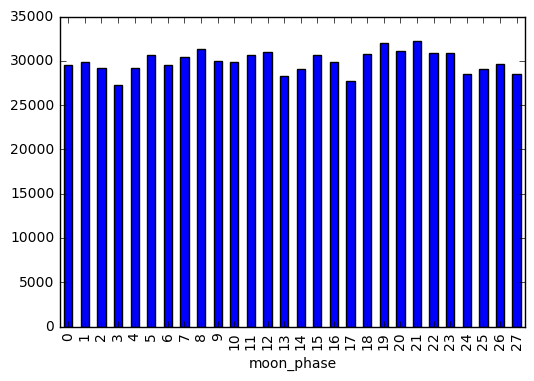

In [8]:
%pylab inline
df.groupby('moon_phase').count()['tr_build_id'].plot(kind='bar')

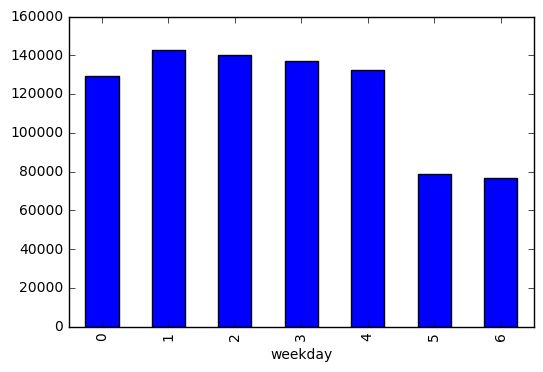

In [9]:
df.groupby('weekday').count()['tr_build_id'].plot(kind='bar')

Well, there seem to be differences between what Travis thinks and what the log parser knows...

In [10]:
df_false_pos.groupby('tr_log_status').count()

,tr_build_id,gh_project_name,git_branch,tr_prev_build,git_num_all_built_commits,gh_sloc,gh_build_started_at,tr_status,group,project,moon_phase,weekday
tr_log_status,,,,,,,,,,,,
broken,40204,40204,40204,26641,40204,40204,40204,40204,40204,40204,40204,40204
cancelled,33,33,33,30,33,33,33,33,33,33,33,33
unknown,99230,99230,99230,74330,99230,99230,99230,99230,99230,99230,99230,99230


Let's have a look at the groups and how many projects they have.

In [11]:
groups.drop_duplicates().groupby('group').count().sort_values('project')

,project
group,
47deg,1
mkdynamic,1
mmozuras,1
mockito,1
mojombo,1
mongodb,1
mongoid-rspec,1
mongomapper,1
morgoth,1


And now some wild correlations!

In [12]:
df_with_prev.corr()

,tr_build_id,tr_prev_build,git_num_all_built_commits,gh_sloc,moon_phase,weekday,tr_build_id_prev,tr_prev_build_prev,git_num_all_built_commits_prev,gh_sloc_prev,moon_phase_prev,weekday_prev
tr_build_id,1.000000,0.997771,-0.001404,0.137655,0.014646,-0.027834,0.997771,0.996884,-0.001329,0.137628,0.014662,-0.028232
tr_prev_build,0.997771,1.000000,-0.002840,0.142522,0.014500,-0.027883,1.000000,0.998907,-0.001270,0.142495,0.014108,-0.028913
git_num_all_built_commits,-0.001404,-0.002840,1.000000,0.006084,0.002817,0.002615,-0.002840,-0.002386,0.005752,0.006052,-0.001257,0.002588
gh_sloc,0.137655,0.142522,0.006084,1.000000,0.007375,-0.016326,0.142522,0.171854,0.008044,0.999970,0.006796,-0.016051
moon_phase,0.014646,0.014500,0.002817,0.007375,1.000000,-0.000190,0.014500,0.014245,-0.002116,0.007369,0.764328,-0.002771
weekday,-0.027834,-0.027883,0.002615,-0.016326,-0.000190,1.000000,-0.027883,-0.031351,0.000785,-0.016300,0.000541,0.615632
tr_build_id_prev,0.997771,1.000000,-0.002840,0.142522,0.014500,-0.027883,1.000000,0.998907,-0.001270,0.142495,0.014108,-0.028913
tr_prev_build_prev,0.996884,0.998907,-0.002386,0.171854,0.014245,-0.031351,0.998907,1.000000,-0.002540,0.171829,0.012666,-0.030539
git_num_all_built_commits_prev,-0.001329,-0.001270,0.005752,0.008044,-0.002116,0.000785,-0.001270,-0.002540,1.000000,0.008045,-0.001597,0.001518
gh_sloc_prev,0.137628,0.142495,0.006052,0.999970,0.007369,-0.016300,0.142495,0.171829,0.008045,1.000000,0.006803,-0.016029


In [13]:
len(df)

837475